# Login

In [1]:
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import qulab
from qulab.tools.wavedata import *

In [2]:
#qulab.admin.register()

In [3]:
qulab.login('liuqichun','123456')

# Driver and Instrument

## Loading

In [4]:
## 加载驱动
path='/Users/liuqichun/Quantum_Lab/qulab/drivers'
for f in os.listdir(path):
    if '.py' in f:
        qulab.admin.uploadDriver(os.path.join(path, f))
ats_driver_path = '/Users/liuqichun/Quantum_Lab/qulab/drivers/AlazarTechDigitizer'
qulab.admin.uploadDriver(ats_driver_path)

In [5]:
## 显示加载的驱动和设备
qulab.listDrivers()

name,version,modules,time
33120A,12,qulab.drivers.33120A,2019-08-15 14:12:34
AFG3102,12,qulab.drivers.AFG3102,2019-08-15 14:12:34
AlazarTechDigitizer,12,qulab.drivers.AlazarTechDigitizer,2019-08-15 14:12:34
,,qulab.drivers.AlazarTechDigitizer.exception,2019-07-23 23:51:05
,,qulab.drivers.AlazarTechDigitizer.AlazarApi,2019-07-23 23:51:05
,,qulab.drivers.AlazarTechDigitizer.AlazarTechWrapper,2019-08-15 14:12:34
,,qulab.drivers.AlazarTechDigitizer.Driver,2019-08-15 14:12:34
DG645,12,qulab.drivers.DG645,2019-08-15 14:12:34
DP800,12,qulab.drivers.DP800,2019-08-15 14:12:34
DPO4104B,12,qulab.drivers.DPO4104B,2019-08-15 14:12:34


In [6]:
## 加载设备
## 采集卡的加载较特殊
qulab.admin.setInstrument('PNA-I', 'localhost', 'TCPIP::192.168.1.103', 'NetworkAnalyzer')
qulab.admin.setInstrument('PSG-I', 'localhost', 'TCPIP::192.168.1.110', 'PSG_SignalGenerator')

## 显示加载的驱动和设备
qulab.listInstruments()
#qulab.listDrivers()

| name | host | address | driver |
|:----|:----|:----|:----|
|AWG|localhost|TCPIP::192.168.1.150|Tek_5014C|
|PNA-I|localhost|TCPIP::192.168.1.103|NetworkAnalyzer|
|PSG-I|localhost|TCPIP::192.168.1.110|PSG_SignalGenerator|

## connecting

In [7]:
## 连接打开设备
#pna=qulab.open_resource('PNA-I')
#awg.create_waveform(name='chanel_1',length=1000)

# app for instrument

In [44]:
qulab.listApps()

package,name,version,author,discription,time
ATS_PACK,ats_acquire,0.0.6,liuqichun,采集卡进行一次数据采集操作,2019-08-19 18:16:38
PNA,S21,0.0.6,liuqichun,从网分上读取 S21,2019-08-16 13:23:23
PNA,three_dim_S21,0.0.7,liuqichun,扫PNA功率进行cavity shift试验,2019-08-16 13:24:00
RBM,RBM_single_point,0.0.7,liuqichun,,2019-08-16 16:11:25
RBM,RBM_line,0.0.7,liuqichun,,2019-08-16 16:30:37
RTO,RTO_find_delay,0.0.7,liuqichun,,2019-08-16 13:24:24
RTO,RTO_line,0.0.7,liuqichun,,2019-08-16 15:18:44
Rabi,three_dim_rabi,0.0.8,liuqichun,扫驱动功率进行单比特3d rabi试验,2019-07-30 13:34:13
Rabi,rabi_line,0.0.16,liuqichun,单比特rabi试验,2019-07-30 14:03:17
awg,awg_generate_waveform,0.0.32,liuqichun,,2019-09-18 10:00:51


## ATS_acquire

In [18]:
import numpy as np
import asyncio
import qulab

class ats_acquire(qulab.Application):
    '''采集卡进行一次数据采集操作
    require:
        rc : ATS
        settings: repeat(optional)
    return: data
    '''
    async def work(self):
        if self.settings.get('tag', 1):
            tag = self.settings.get('tag', 1)
        else:
            tag = 1
        #wave = AlazarTechDigitizer.Driver.Driver.getData()
        #result = wave
        for i in range(tag):
            await asyncio.sleep(0.1)
            yield i, np.random.randn(), np.random.randn()

    @staticmethod
    def plot(fig, data):
        x, I, Q = data
        ax = fig.add_subplot(111)
        ax.plot(x, I, 'ro-')
        ax.plot(x, Q, 'b*-')
        ax.set_xlabel('time (ns)')
        ax.set_ylabel('amp (a.u.)')

In [19]:
ats_acquire.save(package='ATS_PACK')

In [21]:
app = qulab.make_app('ATS_PACK.ats_acquire').with_settings({
    'tag': 10}).with_tags('test ATS acquire data', 'sample 1')
qulab.make_figure_for_app(app)
app.run()

Image(value=b'', format='svg+xml')

## PNA S21

In [11]:
import numpy as np
import skrf as rf
import qulab

class S21(qulab.Application):
    '''从网分上读取 S21
    require:
        rc : PNA
        settings: 以dict形式输入，若未给则按照PNA当前状态进行数据采集
    return: Frequency, Re(S21), Im(S21)
    '''
    async def work(self):
        ## 取重复次数，默认为1次
        if self.settings.get('repeat', 1):
            repeat = self.settings.get('repeat', 1)
        else:
            repeat = 1
        ## 根据settings内容配置PNA参数
        for setting in self.settings:
            if setting is not 'repeat':
                self.rc['PNA'].setValue(setting, self.settings.get(setting,1))
        ## 获取设置好的power和frequency
        if self.params.get('power', None) is None:
            self.params['power'] = [self.rc['PNA'].getValue('Power'), 'dBm']
        x = self.rc['PNA'].get_Frequency()
        ## 进行S21采集
        for i in range(repeat):
            self.processToChange(100.0 / repeat)
            y = np.array(self.rc['PNA'].get_S())
            yield x, np.real(y), np.imag(y)
            self.increaseProcess()

    def pre_save(self, x, re, im):
        if self.data.rows > 1:
            x = x[0]
            re = np.mean(re, axis=0)
            im = np.mean(im, axis=0)
        return x, re, im

    @staticmethod
    def plot(fig, data):
        x, re, im = data
        s = re + 1j * im
        ax = fig.add_subplot(111)
        ax.plot(x / 1e9, rf.mag_2_db(np.abs(s)))
        ax.set_xlabel('Frequency / GHz')
        ax.set_ylabel('S21 / dB')

In [12]:
S21.save(package='PNA')

In [9]:
app = qulab.make_app('PNA.S21').with_rc(
    {'PNA': 'PNA-I'} # PNA-I 必须是已经添加到数据库里的设备名
).with_settings(
    {'repeat': 1,
     'Power': -30,
     'Frequency center': 5.0e9,
     'Frequency span': 100e6,
     'Number of points': 101,
     'Bandwidth': 50,
     'Output': 'ON'}
).with_params(
    power = [-30, 'dBm'],
    att = [-30, 'dB']
).with_tags('5 bits sample', 'Cavity 1')

qulab.make_figure_for_app(app)
app.run()

Image(value=b'', format='svg+xml')

## MW control base

In [176]:
import qulab

class mw_control_base(qulab.Application):
    '''
    对两台MW进行功率和频率设置
    '''
    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'drive_freq': None, 
                        'meas_freq': None,
                        'drive_power': None, 
                        'meas_power': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
        
        ## 设置MW
        if setting_dict['drive_mw_source']:
            drive_mw = qulab.open_resource(setting_dict['drive_mw_source'])
            if setting_dict['drive_power']:
                drive_mw.setValue('Power', setting_dict['drive_power'])
            if setting_dict['f01']:
                drive_mw.setValue('Frequency', setting_dict['drive_freq'])
            drive_mw.setValue('Output', 'ON')
        if setting_dict['meas_mw_source']:
            meas_mw = qulab.open_resource(setting_dict['meas_mw_source'])
            if setting_dict['meas_power']:
                meas_mw.setValue('Power', setting_dict['meas_power'])
            if setting_dict['meas_freq']:
                meas_mw.setValue('Frequency', setting_dict['meas_freq'])
            meas_mw.setValue('Output', 'ON')
        yield 'OK'

In [177]:
mw_control_base.save(package='base_app')

## MW sweep one parameter

In [51]:
import numpy as np
import asyncio
import qulab

class mw_sweep_one_para(qulab.Application):
    '''
    对两台MW进行功率和频率扫描
    可选为meas_mw_freq、meas_mw_power、drive_mw_freq、drive_mw_power
    输入格式为
    app.sweep([('para_x', ***)])
    在with_settings中的sweep_para说明para_x物理上对应上述4组中的哪组
    利用采集卡进行数据采集
    外部传入AWG波形(字典形式作为setting中的一项)，根据传入波形进行设置，而不通过该app生成波形
    若无AWG波形传入，则不对AWG进行设置，认为采用手动设置
    通过该app可以构建S21参数（2D和3D）扫描、qubit能谱测试、单比特时域测试(采用传入AWG波形方式)等
    '''

    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'sweep_para': None,
                        'awg_source': None, 
                        'pulse_mode': False,
                        'wave_in': None,
                        'carry': 50e6, 
                        'wave_length': 10e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'drive_freq': None, 
                        'meas_freq': None,
                        'drive_power': None, 
                        'meas_power': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
        
        ## 根据是否传入AWG波形进行awg设置
        ## 若只给了AWG地址，则生成默认连续的sideband调制
        ## 若同时给了AWG地址和输入波形，则将输入波形发送到AWG
        if setting_dict['awg_source'] is None and setting_dict['wave_in'] is None:
            print('There is no wave setted to awg, please check it.')
        elif setting_dict['awg_source'] and setting_dict['wave_in'] is None:
            pulse=DC(width=setting_dict['wave_length'],sRate=1e9)
            # IQ mixer失配补偿修正，并进行单边调制
            pulse = vIQmixer.carry_wave(carry_freq=setting_dict['carry'],IQ=pulse,
                                        carry_cali=setting_dict['carry_cali'],DEG=True)
            AWG_I = Wavedata.I(pulse).data
            AWG_Q = Wavedata.Q(pulse).data
            # 生成marker信号
            mk1 = DC(width=1e-6,sRate=1e9)
            mk1 = Wavedata.setLen(mk1,setting_dict['wave_length'])
            mk = list(map(int,mk1.data))
            # 拼成完整波形
            ch0 = (AWG_I,mk)
            ch1 = (AWG_Q,mk)
            # 设置AWG
            awg_app = qulab.make_app('awg.awg_generate_waveform').with_rc(
                {'AWG': setting_dict['awg_source']}
            ).with_settings({'ch0':ch0, 'ch1':ch1})
            await awg_app.done()
        else:
            awg_app = qulab.make_app('awg.awg_generate_waveform').with_rc(
                {'AWG': setting_dict['awg_source']}
            ).with_settings(setting_dict['wave_in'])
            await awg_app.done()
        
        ## 设置MW, 扫描参数进行测量
        sweep_para = setting_dict['sweep_para']
        async for x in self.sweep['para_x']:
            setting_dict[sweep_para] = x
            mw_app = qulab.make_app('base_app.mw_control_base').with_settings(
                setting_dict)
            await mw_app.done()
            
            ## 采集卡进行一次数据采集
            ats_app = qulab.make_app('ATS_PACK.ats_acquire')
            i, I, Q = await ats_app.done()
            amp = np.mean(I) + np.mean(Q)
            yield x, amp, sweep_para
            
    async def set_para_x(self, x):
        await asyncio.sleep(0.05)
        
    def pre_save(self, x, amp, sweep_para):
        if  len(sweep_para)> 1:
            sweep_para = sweep_para[0]
        return x, amp, sweep_para

    @staticmethod
    def plot(fig, data):
        x, amp, sweep_para = data
        ax = fig.add_subplot(111)
        if 'power' in sweep_para:
            ax.plot(x, amp)
            ax.set_xlabel('%s (dBm)'%(sweep_para))
            ax.set_ylabel('amp (a.u.)')
        else:
            ax.plot(x/1e9, amp)
            ax.set_xlabel('%s (GHz)'%(sweep_para))
            ax.set_ylabel('amp (a.u.)')

In [52]:
mw_sweep_one_para.save(package='base_app')

In [53]:
setting_dict = {'sweep_para': 'meas_freq',
                'awg_source': None, 
                'pulse_mode': False,
                'wave_in': None,
                'carry': 50e6, 
                'wave_length': 100e-6, 
                'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                'drive_mw_source': None, 
                'meas_mw_source': None, 
                'drive_freq': None, 
                'drive_power': None, 
                'meas_power': None,
                'meas_freq': None}
app = qulab.make_app('base_app.mw_sweep_one_para').sweep([
    ('para_x', np.linspace(4e9,6e9,11))]
).with_settings(setting_dict)

qulab.make_figure_for_app(app)
app.run()

Image(value=b'', format='svg+xml')

There is no wave setted to awg, please check it.


## MW sweep two parameters

In [54]:
import numpy as np
import asyncio
import qulab

class mw_sweep_two_para(qulab.Application):
    '''
    以mw_sweep_one_para.app为基础，增加一维扫描参数
    对两台MW进行功率和频率扫描
    可选为meas_mw_freq、meas_mw_power、drive_mw_freq、drive_mw_power
    输入格式为
    app.sweep([('para_x', ***),('para_y', ***)])
    在with_settings中的sweep_para说明para_x物理上对应上述4组中的哪2组
    如‘sweep_para':['meas_mw_freq','meas_mw_power']
    '''

    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'sweep_para': None,
                        'awg_source': None, 
                        'pulse_mode': False,
                        'wave_in': None,
                        'carry': 50e6, 
                        'wave_length': 10e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'drive_freq': None, 
                        'meas_freq': None,
                        'drive_power': None, 
                        'meas_power': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
        
        ## 临时记录需要进行扫描的para
        para_x = setting_dict['sweep_para'][0]
        para_y = setting_dict['sweep_para'][1]
        # 更新sweep_para为仅保留para_x，以便给mw_sweep_one_para.app
        setting_dict['sweep_para'] = para_x
        ## 扫描para_y
        async for y in self.sweep['para_y']:
            setting_dict[para_y] = y
            mw_app_one_para = qulab.make_app('base_app.mw_sweep_one_para').sweep(
                [('para_x',self.sweep['para_x'])]
            ).with_settings(setting_dict)
            x, amp, para_x = await mw_app_one_para.done()
            sweep_para = {'para_x':para_x,'para_y':para_y}
            yield x, y, amp, sweep_para
        
    async def set_para_y(self, y):
        await asyncio.sleep(0.02)
        
    def pre_save(self, x, y, amp, sweep_para):
        if self.data.rows > 1:
            x = x[0]
            sweep_para = sweep_para[0]
        return x, y, amp, sweep_para
        
    @staticmethod
    def plot(fig, data):
        x, y, z, sweep_para = data
        ax = fig.add_subplot(111)
        if 'freq' in sweep_para['para_x']:
            x_plot_ratio = 1e-9
            x_plot_label = 'GHz'
        else:
            x_plot_ratio = 1
            x_plot_label = 'dBm'
        if 'freq' in sweep_para['para_y']:
            y_plot_ratio = 1e-9
            y_plot_label = 'GHz'
        else:
            y_plot_ratio = 1
            y_plot_label = 'dBm'
        if isinstance(y, np.ndarray):
            ax.imshow(z, extent=(min(x)*x_plot_ratio, max(x)*x_plot_ratio, 
                                 min(y)*y_plot_ratio, max(y)*y_plot_ratio),
                     aspect='auto', origin='lower', interpolation='nearest')
        else:
            ax.plot(x*x_plot_ratio, z)
        ax.set_xlabel('%s (%s)'%(sweep_para['para_x'],x_plot_label))
        ax.set_ylabel('%s (%s)'%(sweep_para['para_y'],y_plot_label))

In [55]:
mw_sweep_two_para.save(package='base_app')

In [56]:
setting_dict = {'sweep_para': ['meas_freq','meas_power'],
                'awg_source': None, 
                'pulse_mode': False,
                'wave_in': None,
                'carry': 50e6, 
                'wave_length': 100e-6, 
                'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                'drive_mw_source': None, 
                'meas_mw_source': None, 
                'drive_freq': None, 
                'drive_power': None, 
                'meas_power': None,
                'meas_freq': None}
app = qulab.make_app('base_app.mw_sweep_two_para').sweep([
    ('para_x', np.linspace(4e9,6e9,11)),
    ('para_y', np.linspace(-50,0,11))]
).with_settings(setting_dict)
qulab.make_figures_for_App('mw_sweep_one_para')
qulab.make_figure_for_app(app)
app.run()

Image(value=b'', format='svg+xml')

There is no wave setted to awg, please check it.
There is no wave setted to awg, please check it.
There is no wave setted to awg, please check it.
There is no wave setted to awg, please check it.
There is no wave setted to awg, please check it.
There is no wave setted to awg, please check it.
There is no wave setted to awg, please check it.
There is no wave setted to awg, please check it.
There is no wave setted to awg, please check it.
There is no wave setted to awg, please check it.
There is no wave setted to awg, please check it.


## AWG generate waveform

In [28]:
import numpy as np
import asyncio
import re
import qulab
from qulab.tools.wavedata import *

class awg_generate_waveform(qulab.Application):
    '''
    输入波形列表，awg输出波形
    采样率固定为1e9，参考时钟为外部
    输入参数：
    app.with_rc({'AWG':'XXXX'}).with_settings({'ch0': ch0_waveform, 'ch1': ch1_waveform})
    波形名称格式为'chx',其中'x'为数字，且只能为1位，’x'对应即为信号输出通道
    波形数据，例如ch0_waveform为2-D array,第1维对应通道模拟信号数据，第2维对应为该通道的marker数据
    with_settings()可以包含其他对awg的设置
    '''
    async def work(self):
        #awg = self.rc['AWG']
        #awg.stop()
        #awg.setValue('Sample rate', 1e9)
        #awg.setValue('Clock source', 'External')
        #awg.setValue('Run Mode', 'Continuous')
        pattern = re.compile(r'ch\d')
        for x in self.settings:
            m = pattern.match(x)
            if m is None:
                #awg.setValue(x, self.settings.get(x,0))
                m = None
            else:
                wavename='wave'+str(x)
                waveform=self.settings.get(x,0)
                '''
                awg.create_waveform(name=wavename, length=len(waveform[0]))
                awg.update_waveform(points=waveform[0], name=wavename)
                awg.update_marker(name=wavename, mk1=waveform[1])
                awg.use_waveform(name=wavename, ch=x[2])
                awg.output_on(ch=x[2])
                '''
        #awg.run()
        yield waveform
    
    @staticmethod
    def plot(fig, waveform):
        ax = fig.add_subplot(111)
        ax.plot(waveform[0], 'r')
        ax.plot(waveform[1], 'b')

In [29]:
awg_generate_waveform.save(package='awg')

In [42]:
import numpy as np
pulse=CosPulse(width=200e-9,sRate=1e9
              )|Blank(width=500e-9,sRate=1e9
                     )|CosPulse(width=200e-9,sRate=1e9)
pulse=DRAG_wd(pulse,a=0.2)
pulse = Wavedata.setLen(pulse,1e-6)
pulse *= Exp(w=2*np.pi*50, phi=0, width=1e-6, sRate=1e9)
AWG_I = Wavedata.I(pulse).data
AWG_Q = Wavedata.Q(pulse).data
mk1 = DC(width=100e-9,sRate=1e9)
mk1 = Wavedata.setLen(mk1,1e-6)
mk = list(map(int,mk1.data))
ch0 = (AWG_I,mk)
ch1 = (AWG_Q,mk)

app = qulab.make_app('awg_generate_waveform', package='awg').with_settings(
    {'ch0': ch0,
     'ch1': ch1,
     'ch3': ch0,
     'ch2': ch0})
#qulab.make_figures_for_App('awg_generate_waveform')
app.run()


# single bit characterize

## Rabi

In [60]:
import numpy as np
import asyncio
import qulab
from qulab.tools.wavedata import *

class rabi_line(qulab.Application):
    '''单比特rabi试验'''
    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'carry': 50e6, 
                        'wave_length': 100e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'awg_source': 'AWG', 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'f01': None, 
                        'drive_power': None, 
                        'meas_power': None,
                        'meas_freq': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
        
        ## 增加setting项目(drive_freq)，提供给mw_control_base.app
        setting_dict['drive_freq'] = setting_dict['f01']-setting_dict['carry']
        ## 设置MW
        mw_app = qulab.make_app('base_app.mw_control_base').with_settings(
            setting_dict)
        await mw_app.done()
        
        ## 扫描驱动长度，进行rabi测试
        async for x in self.sweep['drive_time']:
            if x > 0:
                pulse=CosPulse(width=x,sRate=1e9)
            else:
                pulse=Blank(width=100e-9,sRate=1e9)
            pulse=DRAG_wd(pulse,a=0.1)
            pulse = Wavedata.setLen(pulse,setting_dict['wave_length'])
            # IQ mixer失配补偿修正，并进行单边调制
            pulse = vIQmixer.carry_wave(carry_freq=setting_dict['carry'],IQ=pulse,
                                        carry_cali=setting_dict['carry_cali'],DEG=True)
            AWG_I = Wavedata.I(pulse).data
            AWG_Q = Wavedata.Q(pulse).data
            # 生成marker信号
            mk1 = Blank(width=x,sRate=1e9)|DC(width=1e-6,sRate=1e9)
            mk1 = Wavedata.setLen(mk1,setting_dict['wave_length'])
            mk = list(map(int,mk1.data))
            # 拼成完整波形
            ch0 = (AWG_I,mk)
            ch1 = (AWG_Q,mk)
            ## 设置awg
            awg_app = qulab.make_app('awg.awg_generate_waveform',parent=self).with_settings(
                {'ch0': ch0,
                 'ch1': ch1})
            await awg_app.done()

            # 一定要注意设置 parent
            ats_app = qulab.make_app('ATS_PACK.ats_acquire')
            i, I, Q = await ats_app.done()
            amp = np.mean(I) + np.mean(Q)
            yield x, amp

    async def set_drive_time(self, x):
        await asyncio.sleep(0.02)
    
    @staticmethod
    def plot(fig, data):
        x, amp = data
        ax = fig.add_subplot(111)
        ax.plot(x*1e6, amp, 'b-*')
        ax.set_xlabel('time (us)')
        ax.set_ylabel('amp (a.u.)')

In [61]:
rabi_line.save(package='single_bit_characterize')

In [62]:
setting_dict = {'carry': 50e6, 
                'wave_length': 100e-6, 
                'carry_cali': [[1.0, 0.02, 0.0], [1.0, -0.02, 0.0]], 
                'awg_source': 'AWG', 
                'drive_mw_source': None, 
                'meas_mw_source': None, 
                'f01': 7.5e9, 
                'drive_power': None, 
                'meas_power': None,
                'meas_freq': None}

app = qulab.make_app('rabi_line', package='single_bit_characterize').sweep([
    ('drive_time', np.linspace(0, 100e-6, 11))]
).with_settings(
    setting_dict
).with_params(
    power = [-27, 'dBm'],
    att = [-30, 'dB']
).with_tags('Q1 rabi', 'Cavity 1')
qulab.make_figure_for_app(app)
app.run()

Image(value=b'', format='svg+xml')

## T1

In [217]:
import numpy as np
import asyncio
import qulab
from qulab.tools.wavedata import *

class T1_line(qulab.Application):
    '''单比特T1试验'''
    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'carry': 50e6, 
                        'pi_width': None,
                        'wave_length': 100e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'awg_source': 'AWG', 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'f01': None, 
                        'drive_power': None, 
                        'meas_power': None,
                        'meas_freq': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
                
        ## 增加setting项目(drive_freq)，提供给mw_control_base.app
        setting_dict['drive_freq'] = setting_dict['f01']-setting_dict['carry']
        ## 设置MW
        mw_app = qulab.make_app('base_app.mw_control_base',parent=self).with_settings(
            setting_dict)
        await mw_app.done()
        
        ## 进行T1测试
        async for x in self.sweep['delay_time']:
            pulse=CosPulse(width=setting_dict['pi_width'],sRate=1e9)
            pulse=DRAG_wd(pulse,a=0.1)
            pulse = Wavedata.setLen(pulse,setting_dict['wave_length'])
            # IQ mixer失配补偿修正，并进行单边调制
            pulse = vIQmixer.carry_wave(carry_freq=setting_dict['carry'],IQ=pulse,
                                        carry_cali=setting_dict['carry_cali'],DEG=True)
            AWG_I = Wavedata.I(pulse).data
            AWG_Q = Wavedata.Q(pulse).data
            # 生成marker信号
            mk1 = Blank(width=x+setting_dict['pi_width'],sRate=1e9)|DC(width=1e-6,sRate=1e9)
            mk1 = Wavedata.setLen(mk1,setting_dict['wave_length'])
            mk = list(map(int,mk1.data))
            # 拼成完整波形
            ch0 = (AWG_I,mk)
            ch1 = (AWG_Q,mk)
            
            ## 设置awg
            awg_app = qulab.make_app('awg.awg_generate_waveform',parent=self).with_rc(
                {'AWG': setting_dict['awg_source']}
            ).with_settings(
                {'ch0': ch0,
                 'ch1': ch1})
            await awg_app.done()
            # 一定要注意设置 parent
            ats_app = qulab.make_app('ATS_PACK.ats_acquire', parent=self)
            i, I, Q = await ats_app.done()
            amp = np.mean(I) + np.mean(Q)
            yield x, amp

    async def set_delay_time(self, x):
        await asyncio.sleep(0.2)

    @staticmethod
    def plot(fig, data):
        x, amp = data
        ax = fig.add_subplot(111)
        ax.plot(x*1e6, amp, 'r')
        ax.set_xlabel('time (us)')
        ax.set_ylabel('amp (a.u.)')

In [218]:
T1_line.save(package='single_bit_characterize')

In [219]:
setting_dict = {'carry': 50e6, 
                'pi_width': 50e-9,
                'wave_length': 100e-6, 
                'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                'awg_source': 'AWG', 
                'drive_mw_source': None, 
                'meas_mw_source': None, 
                'f01': 7.5e9, 
                'drive_power': None, 
                'meas_power': None,
                'meas_freq': None}

app = qulab.make_app('T1_line', package='single_bit_characterize').sweep([
    ('delay_time', np.linspace(0, 100e-6, 11))]
).with_settings(
    setting_dict
).with_params(
    power = [-27, 'dBm'],
    att = [-30, 'dB']
).with_tags('Q1 rabi', 'Cavity 1')
qulab.make_figure_for_app(app)
app.run()

Image(value=b'', format='svg+xml')

## Ramsey

In [63]:
import numpy as np
import asyncio
import qulab
from qulab.tools.wavedata import *

class ramsey_line(qulab.Application):
    '''单比特ramsey试验'''
    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'carry': 50e6, 
                        'pi_2_width': None,
                        'wave_length': 100e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'awg_source': 'AWG', 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'f01': None, 
                        'drive_power': None, 
                        'meas_power': None,
                        'meas_freq': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
                
        ## 增加setting项目(drive_freq)，提供给mw_control_base.app
        setting_dict['drive_freq'] = setting_dict['f01']-setting_dict['carry']
        ## 设置MW
        mw_app = qulab.make_app('base_app.mw_control_base').with_settings(
            setting_dict)
        await mw_app.done()
        
        ## 进行ramsey测试
        async for x in self.sweep['delay_time']:
            if x > 0:
                pulse=CosPulse(width=setting_dict['pi_2_width'],sRate=1e9
                              )|Blank(width=x,sRate=1e9
                                     )|CosPulse(width=setting_dict['pi_2_width'],sRate=1e9)
            else:
                pulse=CosPulse(width=setting_dict['pi_2_width'],sRate=1e9
                              )|CosPulse(width=setting_dict['pi_2_width'],sRate=1e9)
            pulse=DRAG_wd(pulse,a=0.1)
            pulse = Wavedata.setLen(pulse,setting_dict['wave_length'])
            # IQ mixer失配补偿修正，并进行单边调制
            pulse = vIQmixer.carry_wave(carry_freq=setting_dict['carry'],IQ=pulse,
                                        carry_cali=setting_dict['carry_cali'],DEG=True)
            AWG_I = Wavedata.I(pulse).data
            AWG_Q = Wavedata.Q(pulse).data
            # 生成marker信号
            mk1 = Blank(width=x+2*setting_dict['pi_2_width'],sRate=1e9)|DC(width=1e-6,sRate=1e9)
            mk1 = Wavedata.setLen(mk1,setting_dict['wave_length'])
            mk = list(map(int,mk1.data))
            # 拼成完整波形
            ch0 = (AWG_I,mk)
            ch1 = (AWG_Q,mk)
            
            ## 设置awg
            awg_app = qulab.make_app('awg.awg_generate_waveform',parent=self).with_rc(
                {'AWG': setting_dict['awg_source']}
            ).with_settings(
                {'ch0': ch0,
                 'ch1': ch1})
            await awg_app.done()
            # 一定要注意设置 parent
            ats_app = qulab.make_app('ATS_PACK.ats_acquire')
            i, I, Q = await ats_app.done()
            amp = np.mean(I) + np.mean(Q)
            yield x, amp

    async def set_delay_time(self, x):
        await asyncio.sleep(0.2)

    @staticmethod
    def plot(fig, data):
        x, amp = data
        ax = fig.add_subplot(111)
        ax.plot(x*1e6, amp, 'r')
        ax.set_xlabel('time (us)')
        ax.set_ylabel('amp (a.u.)')

In [64]:
ramsey_line.save(package='single_bit_characterize')

In [65]:
setting_dict = {'carry': 50e6, 
                'pi_width': 50e-9,
                'pi_2_width': 25e-9,
                'wave_length': 100e-6, 
                'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                'awg_source': 'AWG', 
                'drive_mw_source': None, 
                'meas_mw_source': None, 
                'f01': 7.5e9, 
                'drive_power': None, 
                'meas_power': None,
                'meas_freq': None}

app = qulab.make_app('ramsey_line', package='single_bit_characterize').sweep([
    ('delay_time', np.linspace(0, 100e-6, 11))]
).with_settings(
    setting_dict
).with_params(
    power = [-27, 'dBm'],
    att = [-30, 'dB']
).with_tags('Q1 rabi', 'Cavity 1')
qulab.make_figure_for_app(app)
app.run()

Image(value=b'', format='svg+xml')

## Spin echo

In [66]:
import numpy as np
import asyncio
import qulab
from qulab.tools.wavedata import *

class echo_line(qulab.Application):
    '''单比特spin echo试验'''
    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'carry': 50e6, 
                        'pi_2_width': None,
                        'pi_width': None,
                        'wave_length': 100e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'awg_source': 'AWG', 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'f01': None, 
                        'drive_power': None, 
                        'meas_power': None,
                        'meas_freq': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
                
        ## 增加setting项目(drive_freq)，提供给mw_control_base.app
        setting_dict['drive_freq'] = setting_dict['f01']-setting_dict['carry']
        ## 设置MW
        mw_app = qulab.make_app('base_app.mw_control_base').with_settings(
            setting_dict)
        await mw_app.done()
        
        ## 进行echo测试
        async for x in self.sweep['delay_time']:
            if x > 0:
                pulse=CosPulse(width=setting_dict['pi_2_width'],sRate=1e9
                              )|Blank(width=int(x/2),sRate=1e9
                                     )|CosPulse(width=setting_dict['pi_width'],sRate=1e9
                                               )|Blank(width=int(x/2),sRate=1e9
                                                      )|CosPulse(width=setting_dict['pi_2_width'],sRate=1e9)
            else:
                pulse=CosPulse(width=setting_dict['pi_2_width'],sRate=1e9
                              )|CosPulse(width=setting_dict['pi_width'],sRate=1e9
                                        )|CosPulse(width=setting_dict['pi_2_width'],sRate=1e9)
            pulse=DRAG_wd(pulse,a=0.1)
            pulse = Wavedata.setLen(pulse,setting_dict['wave_length'])
            # IQ mixer失配补偿修正，并进行单边调制
            pulse = vIQmixer.carry_wave(carry_freq=setting_dict['carry'],IQ=pulse,
                                        carry_cali=setting_dict['carry_cali'],DEG=True)
            AWG_I = Wavedata.I(pulse).data
            AWG_Q = Wavedata.Q(pulse).data
            # 生成marker信号
            mk1 = Blank(width=x+2*setting_dict['pi_width'],sRate=1e9)|DC(width=1e-6,sRate=1e9)
            mk1 = Wavedata.setLen(mk1,setting_dict['wave_length'])
            mk = list(map(int,mk1.data))
            # 拼成完整波形
            ch0 = (AWG_I,mk)
            ch1 = (AWG_Q,mk)
            
            ## 设置awg
            awg_app = qulab.make_app('awg.awg_generate_waveform',parent=self).with_rc(
                {'AWG': setting_dict['awg_source']}
            ).with_settings(
                {'ch0': ch0,
                 'ch1': ch1})
            await awg_app.done()
            # 一定要注意设置 parent
            ats_app = qulab.make_app('ATS_PACK.ats_acquire')
            i, I, Q = await ats_app.done()
            amp = np.mean(I) + np.mean(Q)
            yield x, amp

    async def set_delay_time(self, x):
        await asyncio.sleep(0.2)

    @staticmethod
    def plot(fig, data):
        x, amp = data
        ax = fig.add_subplot(111)
        ax.plot(x*1e6, amp, 'r')
        ax.set_xlabel('time (us)')
        ax.set_ylabel('amp (a.u.)')

In [67]:
echo_line.save(package='single_bit_characterize')

In [68]:
setting_dict = {'carry': 50e6, 
                'pi_width': 50e-9,
                'pi_2_width': 25e-9,
                'wave_length': 100e-6, 
                'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                'awg_source': 'AWG', 
                'drive_mw_source': None, 
                'meas_mw_source': None, 
                'f01': 7.5e9, 
                'drive_power': None, 
                'meas_power': None,
                'meas_freq': None}

app = qulab.make_app('echo_line', package='single_bit_characterize').sweep([
    ('delay_time', np.linspace(0, 100e-6, 11))]
).with_settings(
    setting_dict
).with_params(
    power = [-27, 'dBm'],
    att = [-30, 'dB']
).with_tags('Q1 rabi', 'Cavity 1')
qulab.make_figure_for_app(app)
app.run()

Image(value=b'', format='svg+xml')

## 3D S21 sweep PNA power

In [23]:
import numpy as np
import skrf as rf
import asyncio
import qulab

class three_dim_S21(qulab.Application):
    '''扫PNA功率进行cavity shift试验'''
    async def work(self):
        async for y in self.sweep['power']:
            # 一定要注意设置 parent
            S21_app = qulab.make_app('PNA.S21', parent=self).with_settings({'Power': y})
            freq, re, im = await S21_app.done()
            amp = rf.mag_2_db(np.abs(re + 1j * im))
            yield freq, y, amp

    async def set_power(self, y):
        await asyncio.sleep(0.3)
    
    def pre_save(self, freq, y, amp):
        if self.data.rows > 1:
            freq = freq[0]
        return freq, y, amp

    @staticmethod
    def plot(fig, data):
        x, y, z = data
        ax = fig.add_subplot(111)
        if isinstance(y, np.ndarray):
            ax.imshow(z, extent=(min(x)/1e9, max(x)/1e9, min(y), max(y)),
                     aspect='auto', origin='lower', interpolation='nearest')
        else:
            ax.plot(x/1e9, z)
        ax.set_xlabel('frequency (GHz)')
        ax.set_ylabel('power (dBm)')

In [24]:
three_dim_S21.save(package='PNA')

In [163]:
pna = qulab.open_resource('PNA-I')
pna_settings = {'repeat': 1,
                'Power': -30,
                'Frequency center': 5.0e9,
                'Frequency span': 100e6,
                'Number of points': 101,
                'Bandwidth': 50,
                'Output': 'ON'}
for setting in pna_settings:
    pna.setValue(setting, pna_settings[setting])

three_dim_S21_app = qulab.make_app('three_dim_S21', package='PNA').with_rc(
    {'PNA':'PNA-I'}).sweep(
    [('power', np.linspace(-30,0,5))])
qulab.make_figure_for_app(three_dim_S21_app)
three_dim_S21_app.run()

KeyboardInterrupt: 

## 3D Rabi sweep MW power

In [69]:
import numpy as np
import asyncio
import qulab

class three_dim_rabi(qulab.Application):
    '''扫驱动功率进行单比特3d rabi试验'''
    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'carry': 50e6, 
                        'wave_length': 100e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'awg_source': 'AWG', 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'f01': None, 
                        'drive_power': None, 
                        'meas_power': None,
                        'meas_freq': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
        
        async for y in self.sweep['drive_power']:
            setting_dict['drive_power'] = y
            rabi_app = qulab.make_app('single_bit_characterize.rabi_line').sweep(
                [('drive_time', self.sweep['drive_time'])]
            ).with_settings(
                setting_dict)
            time, amp = await rabi_app.done()
            yield time, y, amp

    async def set_drive_power(self, y):
        await asyncio.sleep(0.3)
    
    def pre_save(self, time, y, amp):
        if self.data.rows > 1:
            time = time[0]
        return time, y, amp

    @staticmethod
    def plot(fig, data):
        x, y, z = data
        ax = fig.add_subplot(111)
        if isinstance(y, np.ndarray):
            ax.imshow(z, extent=(min(x)*1e6, max(x)*1e6, min(y), max(y)),
                     aspect='auto', origin='lower', interpolation='nearest')
        else:
            ax.plot(x*1e6, z)
        ax.set_xlabel('time (us)')
        ax.set_ylabel('power (dBm)')

In [70]:
three_dim_rabi.save(package='single_bit_characterize')

In [71]:
setting_dict = {'carry': 50e6, 
                'wave_length': 100e-6, 
                'carry_cali': [[1.0, 0.02, 0.0], [1.0, -0.02, 0.0]], 
                'awg_source': 'AWG', 
                'drive_mw_source': None, 
                'meas_mw_source': None, 
                'f01': 7.5e9, 
                'drive_power': None, 
                'meas_power': None,
                'meas_freq': None}

three_dim_rabi_app = qulab.make_app('three_dim_rabi', package='single_bit_characterize').sweep(
    [('drive_time', np.linspace(10e-9,100e-6,5)),
     ('drive_power', np.linspace(-30,0,5))]
).with_settings(
    setting_dict)
qulab.make_figures_for_App('rabi_line')
qulab.make_figure_for_app(three_dim_rabi_app)
three_dim_rabi_app.run()

Image(value=b'', format='svg+xml')

# Wavedata Example

## Filter

<IPython.core.display.Javascript object>


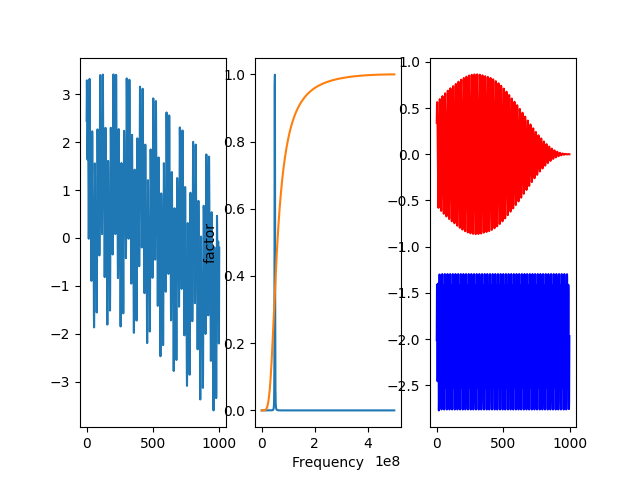

In [21]:
#### 定义原始波形
signal_1 = Sin(w=2*np.pi*50e6, phi=0, width=1e-6, sRate=1e9)
signal_2 = Sin(w=2*np.pi*10e6, phi=np.pi/4, width=1e-6, sRate=1e9)
signal_3 = Sin(w=2*np.pi*0.5e6, phi=np.pi/3, width=1e-6, sRate=1e9)
signal_4 = Sin(w=2*np.pi*100e6, phi=np.pi/7, width=1e-6, sRate=1e9)
signal = signal_1 + signal_2 + signal_3 + signal_4
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax1.plot(signal.data)
### 定义滤波器，并绘制响应曲线
IF_filter = F.IIRFilter(N=3, Wn=[49e6, 50e6], rp=0.01, rs=100, btype='band', ftype='ellip', fs=1e9)
BS_filter = F.BesselFilter(N=5, Wn=50e6, btype='high', norm='phase', fs=1e9)
ax2 = fig.add_subplot(132)
IF_filter.plot()
BS_filter.plot()
### 对数字信号进行滤波，输入为np.array和采样率
result_1 = IF_filter.process(signal.data, signal.sRate)
result_2 = BS_filter.process(signal.data, signal.sRate)
data = result_1[0]
sRate = result_1[1]
ax3 = fig.add_subplot(133)
ax3.plot(data,'r')
ax3.plot(result_2[0]-2,'b')

## data fit

<IPython.core.display.Javascript object>


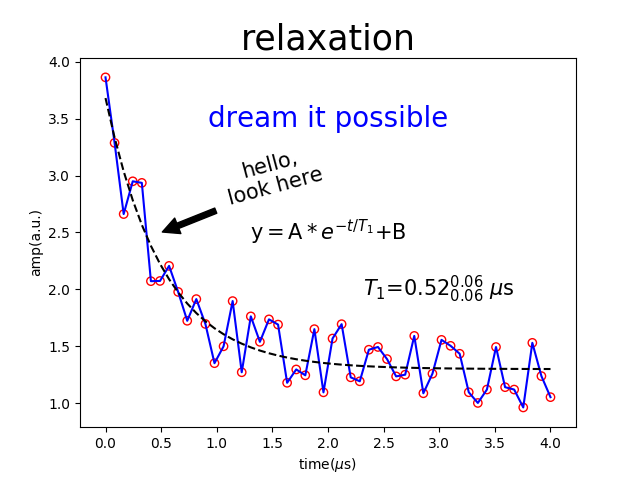

Text(2, 2.5, '$\\mathrm{y=A*}$$e^{-t/T_1}$$\\mathrm{+B}$')

In [117]:
from qulab.tools.datafit import *
def func(t, A, B, T1):
    '''this an example: T1 fit function '''
    y=A*np.exp(-t/T1)+B
    return y
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(72)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xdata, ydata, 'b-', label='data')

fit = T1_Fit((xdata,ydata))
fit.plot()

ax.set_title('relaxation',fontsize=25)
ax.set_xlabel('time($\mu$s)')
ax.set_ylabel('amp(a.u.)')

ax.annotate('hello,'+'\n'+'look here', xy=(0.5, 2.5), xytext=(1.5, 3), 
            fontsize=15,rotation=15,
            verticalalignment="center",
            horizontalalignment="center",
            arrowprops=dict(facecolor='black', shrink=0.02))

ax.text(2,3.5,'dream it possible',fontsize=20, color='b',
        verticalalignment="center",
        horizontalalignment="center")

ax.text(3,2,'$T_1$='+str(round(fit.T1,2))
        +'$_{%.2f}^{%.2f}$'%(fit.T1_error,fit.T1_error)
        +' $\mu$'+'s',fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

ax.text(2,2.5,'$\mathrm{y=A*}$'+'$e^{-t/T_1}$'+'$\mathrm{+B}$',
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

# Ramsey Tomography Oscilloscope

## find the optimised delay

In [91]:
import numpy as np
import asyncio
import qulab
from qulab.tools.wavedata import *

class RTO_find_delay(qulab.Application):
    '''
    找RTO测试的最佳delay时间，同时也得到驱动频率偏移量
    app.sweep(delay_time): 待测试的delay序列
    
    输入参数，都是采用with_settings方式输入:
    carry: sideband频率
    pi_2_width: pi/2脉冲长度
    wave_length: 波形总长度
    carry_cali: IQ mixer校正矩阵
    awg_source: awg设备name
    drive_mw_source: 驱动mw设备name
    meas_mw_source: 测量mw设备name
    f01: qubit频率
    drive_power: 驱动mw功率
    meas_power: 测量mw功率
    meas_freq: 测量mw频率
    '''
    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'carry': 50e6, 
                        'pi_2_width': None,
                        'wave_length': 100e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'awg_source': 'AWG', 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'f01': None, 
                        'drive_power': None, 
                        'meas_power': None,
                        'meas_freq': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
        
        ## 对不同的delay time进行测试，得到py/px变化最敏感的工作点
        async for x in self.sweep['delay_time']:
            ### 分别测量py和px
            ### 一个波形周期内，先测量py，后测量px，采集卡不进行平均处理，
            ### 不能px、py交替，采集卡无法确认先采集的是哪个
            ### 需要手动分别对采集数据的奇偶项进行平均，得到py和px
            
            ## 根据delay time生成awg波形
            pulse1=DRAGpulse(width=setting_dict['pi_2_width'],sRate=1e9,a=0.2
                            )|Blank(width=x,sRate=1e9
                                   )|DRAGpulse(width=setting_dict['pi_2_width'],sRate=1e9,a=0.2)
            pulse1 = Wavedata.setLen(pulse1,setting_dict['wave_length'])
            pulse2=DRAGpulse(width=setting_dict['pi_2_width'],sRate=1e9,a=0.2
                            )|Blank(width=x,sRate=1e9
                                   )|1j*DRAGpulse(width=setting_dict['pi_2_width'],sRate=1e9,a=0.2)
            pulse2 = Wavedata.setLen(pulse2,setting_dict['wave_length'])
            ## 合并测量py和px的波形
            pulse = pulse1|pulse2
            # IQ mixer失配补偿修正，并进行单边调制
            pulse = vIQmixer.carry_wave(carry_freq=setting_dict['carry'],IQ=pulse,
                                        carry_cali=setting_dict['carry_cali'],DEG=True)
            AWG_I = Wavedata.I(pulse).data
            AWG_Q = Wavedata.Q(pulse).data
            # 生成marker信号
            mk1 = Blank(width=x+2*setting_dict['pi_2_width'],sRate=1e9)|DC(width=1e-6,sRate=1e9)
            mk1 = Wavedata.setLen(mk1,setting_dict['wave_length'])
            mk1 = mk1|mk1
            mk = list(map(int,mk1.data))
            # 拼成完整波形
            ch0 = (AWG_I,mk)
            ch1 = (AWG_Q,mk)
            ## 计算delay time对应的驱动频率,并设置MW
            ## 增加setting项目(drive_freq)，提供给mw_control_base.app
            setting_dict['drive_freq'] = int(setting_dict['f01']-setting_dict['carry']-0.25/x)
            ## 设置MW
            mw_app = qulab.make_app('base_app.mw_control_base').with_settings(
                setting_dict)
            await mw_app.done()
            
            ## 设置awg
            awg_app = qulab.make_app('awg.awg_generate_waveform',parent=self).with_rc(
                {'AWG': setting_dict['awg_source']}
            ).with_settings(
                {'ch0': ch0,
                 'ch1': ch1})
            await awg_app.done()
            
            ## ATS采集一次数据
            ats_app = qulab.make_app('ATS_PACK.ats_acquire')
            i, I, Q = await ats_app.done()
            amp = np.mean(I) + np.mean(Q)

            out = [amp, amp]
            ## 根据测量的py/px计算qubit频率在delay time内的变化
            delta_f01 = np.arctan(out[0]/out[1])/(2*np.pi*x)
            yield x, delta_f01

    async def set_delay_time(self, x):
        await asyncio.sleep(0.02)

    @staticmethod
    def plot(fig, data):
        x, delta_f01 = data
        ax = fig.add_subplot(111)
        ax.plot(x*1e6, delta_f01/1e6, 'r')
        ax.set_xlabel('time (us)')
        ax.set_ylabel('delta_f01 (MHz)')

In [92]:
RTO_find_delay.save(package='RTO')

In [93]:
setting_dict = {'carry': 50e6, 
                'pi_2_width': 25e-9,
                'wave_length': 100e-6, 
                'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                'awg_source': 'AWG', 
                'drive_mw_source': None, 
                'meas_mw_source': None, 
                'f01': 5e9, 
                'drive_power': None, 
                'meas_power': None,
                'meas_freq': None}
RTO_app = qulab.make_app('RTO.RTO_find_delay').sweep(
    [('delay_time', np.linspace(0.01e-6,2.01e-6,11))]
).with_settings(
    setting_dict)
qulab.make_figure_for_app(RTO_app)
RTO_app.run()

Image(value=b'', format='svg+xml')

## RTO

In [119]:
import numpy as np
import asyncio
import qulab
from qulab.tools.wavedata import *

class RTO_line(qulab.Application):
    '''
    根据最佳delay时间，进行RTO测试    
    输入参数，都是采用with_settings方式输入:
    points: 采样点数
    delay_time: 最佳delay时间
    carry: sideband频率
    pi_2_width: pi/2脉冲长度
    wave_length: 波形总长度
    carry_cali: IQ mixer校正矩阵
    awg_source: awg设备name
    drive_mw_source: 驱动mw设备name
    meas_mw_source: 测量mw设备name
    f01: qubit频率
    drive_power: 驱动mw功率
    meas_power: 测量mw功率
    meas_freq: 测量mw频率
    '''
    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'points': 1000,
                        'delay_time': None,
                        'carry': 50e6, 
                        'pi_2_width': None,
                        'wave_length': 100e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'awg_source': 'AWG', 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'f01': None, 
                        'drive_power': None, 
                        'meas_power': None,
                        'meas_freq': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
        
        ## 计算delay time对应的驱动频率,并设置MW
        ## 增加setting项目(drive_freq)，提供给mw_control_base.app
        setting_dict['drive_freq'] = int(setting_dict['f01']-setting_dict['carry']
                                         -0.25/setting_dict['delay_time'])
        ## 设置MW
        mw_app = qulab.make_app('base_app.mw_control_base',parent=self).with_settings(
            setting_dict)
        await mw_app.done()
        
        ## 根据delay time生成awg波形
        pulse1=DRAGpulse(width=setting_dict['pi_2_width'],sRate=1e9,a=0.2
                        )|Blank(width=setting_dict['delay_time'],sRate=1e9
                               )|DRAGpulse(width=setting_dict['pi_2_width'],sRate=1e9,a=0.2)
        pulse1 = Wavedata.setLen(pulse1,setting_dict['wave_length'])
        pulse2=DRAGpulse(width=setting_dict['pi_2_width'],sRate=1e9,a=0.2
                        )|Blank(width=setting_dict['delay_time'],sRate=1e9
                               )|1j*DRAGpulse(width=setting_dict['pi_2_width'],sRate=1e9,a=0.2)
        pulse2 = Wavedata.setLen(pulse2,setting_dict['wave_length'])
        ## 合并测量py和px的波形
        pulse = pulse1|pulse2
        # IQ mixer失配补偿修正，并进行单边调制
        pulse = vIQmixer.carry_wave(carry_freq=setting_dict['carry'],IQ=pulse,
                                    carry_cali=setting_dict['carry_cali'],DEG=True)
        AWG_I = Wavedata.I(pulse).data
        AWG_Q = Wavedata.Q(pulse).data
        # 生成marker信号
        mk1 = Blank(width=setting_dict['delay_time']+2*setting_dict['pi_2_width'],sRate=1e9
                   )|DC(width=1e-6,sRate=1e9)
        mk1 = Wavedata.setLen(mk1,setting_dict['wave_length'])
        mk1 = mk1|mk1
        mk = list(map(int,mk1.data))
        # 拼成完整波形
        ch0 = (AWG_I,mk)
        ch1 = (AWG_Q,mk)
        ## 设置awg
        awg_app = qulab.make_app('awg.awg_generate_waveform',parent=self).with_rc(
            {'AWG': setting_dict['awg_source']}
        ).with_settings(
            {'ch0': ch0,
             'ch1': ch1})
        await awg_app.done()
        
        ## 连续进行points次采样，得到delta_f01序列
        for x in range(setting_dict['points']):
            ## ATS采集一次数据
            ats_app = qulab.make_app('ATS_PACK.ats_acquire')
            i, I, Q = await ats_app.done()
            amp = np.mean(I) + np.mean(Q)
            
            out = [amp, amp]
            ## 根据测量的py/px计算qubit频率在delay time内的变化
            delta_f01 = np.arctan(out[0]/out[1])/(2*np.pi*x)
            yield x, delta_f01

    @staticmethod
    def plot(fig, data):
        x, delta_f01 = data
        ax = fig.add_subplot(111)
        ax.plot(x/5, delta_f01/1e6, 'r')
        ax.set_xlabel('time (s)')
        ax.set_ylabel('delta_f01 (MHz)')

In [120]:
RTO_line.save(package='RTO')

In [121]:
setting_dict = {'points': 20,
                'delay_time': 25e-9,
                'carry': 50e6, 
                'pi_2_width': 25e-9,
                'wave_length': 100e-6, 
                'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                'awg_source': 'AWG', 
                'drive_mw_source': None, 
                'meas_mw_source': None, 
                'f01': 5e9, 
                'drive_power': None, 
                'meas_power': None,
                'meas_freq': None}
RTO_app = qulab.make_app('RTO.RTO_line').with_settings(setting_dict)
qulab.make_figure_for_app(RTO_app)
RTO_app.run()

Image(value=b'', format='svg+xml')

db://id-5d81d232bf447c68b4b5ac59/qulab/apps/codeID5d81d232bf447c68b4b5ac58.py:94: RuntimeWarning: divide by zero encountered in double_scalars


# Clifford RBM

## RBM_single_point

In [137]:
import numpy as np
import asyncio
import qulab
from qulab.tools.wavedata import *
from qulab.tools.cliffordgroup import *

class RBM_single_point(qulab.Application):
    '''
    根据是否给定待标定门的序号，进行参考序列或者标定序列中一个点的测量 
    输入参数，都是采用with_settings方式输入:
    target_gate_num: 0-23之间的数组，对应待标定门，若未None则表示进行参考序列测量
    sequence_num: RBM序列门操作数
    repeat: 重复次数
    carry: sideband频率
    pi_array: 格式为[100e-9,1,50e-9,1]，表示pi、pi_2的长度、幅度
    wave_length: 波形总长度
    carry_cali: IQ mixer校正矩阵
    awg_source: awg设备name
    drive_mw_source: 驱动mw设备name
    meas_mw_source: 测量mw设备name
    f01: qubit频率
    drive_power: 驱动mw功率
    meas_power: 测量mw功率
    meas_freq: 测量mw频率
    '''
    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'target_gate_num': None,
                        'sequence_num': 1,
                        'repeat': 1,
                        'carry': 50e6, 
                        'pi_array': [100e-9,1,50e-9,1],
                        'wave_length': 100e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'awg_source': 'AWG', 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'f01': None, 
                        'drive_power': None, 
                        'meas_power': None,
                        'meas_freq': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
        
        ## 增加setting项目(drive_freq)，提供给mw_control_base.app
        setting_dict['drive_freq'] = int(setting_dict['f01']-setting_dict['carry'])
        ## 设置MW
        mw_app = qulab.make_app('base_app.mw_control_base').with_settings(
            setting_dict)
        await mw_app.done()
        
        for idx in range(setting_dict['repeat']):
            ## 生成awg波形,含DRAG修正
            RB_G=cliffordGroup()
            if setting_dict['target_gate_num']:
                RB_seq=cliffordGroup.rbm_seq(RB_G,size=setting_dict['sequence_num'],
                                             group=None,ref=setting_dict['target_gate_num'])
            else:
                RB_seq=cliffordGroup.rbm_seq(RB_G,size=setting_dict['sequence_num'],
                                             group=None,ref=[])
            RB_W=cliffordGroup.rbm_wd(RB_G,indexseq=RB_seq, 
                                      pi_array=setting_dict['pi_array'], 
                                      sRate=1e9, buffer=2e-9, 
                                      TYPE=CosPulse)
            pulse_length = len(RB_W.data)/1e9
            RB_W=Wavedata.setLen(RB_W,setting_dict['wave_length'])
            RB_W_DRAG=cliffordGroup.rbm_wd_drag(RB_G,indexseq=RB_seq, 
                                                pi_array=setting_dict['pi_array'], 
                                                sRate=1e9, buffer=2e-9, 
                                                TYPE=CosPulse)
            RB_W_DRAG=Wavedata.setLen(RB_W_DRAG,setting_dict['wave_length'])
            pulse = RB_W+1j*RB_W_DRAG*0.2
            # IQ mixer失配补偿修正，并进行单边调制
            pulse = vIQmixer.carry_wave(carry_freq=setting_dict['carry'],IQ=pulse,
                                        carry_cali=setting_dict['carry_cali'],DEG=True)
            AWG_I = Wavedata.I(pulse).data
            AWG_Q = Wavedata.Q(pulse).data
            # 生成marker信号
            mk1 = Blank(width=pulse_length,sRate=1e9)|DC(width=1e-6,sRate=1e9)
            mk1 = Wavedata.setLen(mk1,setting_dict['wave_length'])
            mk1 = mk1|mk1
            mk = list(map(int,mk1.data))
            # 拼成完整波形
            ch0 = (AWG_I,mk)
            ch1 = (AWG_Q,mk)
            
            ## 设置awg
            awg_app = qulab.make_app('awg.awg_generate_waveform',parent=self).with_rc(
                {'AWG': setting_dict['awg_source']}
            ).with_settings(
                {'ch0': ch0,
                 'ch1': ch1})
            await awg_app.done()
        
            ## ATS采集一次数据
            ats_app = qulab.make_app('ATS_PACK.ats_acquire', parent=self)
            i, I, Q = await ats_app.done()
            amp = np.mean(I) + np.mean(Q)
            yield amp
        
    @staticmethod
    def plot(fig, data):
        ax = fig.add_subplot(111)
        ax.plot(data, 'ro')
        ax.set_xlabel('repeation')
        ax.set_ylabel('sequency fidelity')

In [138]:
RBM_single_point.save(package='RBM')

## RBM_line

In [144]:
import numpy as np
import asyncio
import qulab
from qulab.tools.wavedata import *
from qulab.tools.cliffordgroup import *

class RBM_line(qulab.Application):
    '''
    根据是否给定待标定门的序号，进行参考序列或者标定序列测量
    app.sweep([sequence_num]): 待测量的RBM序列门操作数的array
    
    输入参数，都是采用with_settings方式输入:
    target_gate_num: 0-23之间的数组，对应待标定门，若未None则表示进行参考序列测量
    sequence_num: RBM序列门操作数
    repeat: 重复次数
    carry: sideband频率
    pi_array: 格式为[100e-9,1,50e-9,1]，表示pi、pi_2的长度、幅度
    wave_length: 波形总长度
    carry_cali: IQ mixer校正矩阵
    awg_source: awg设备name
    drive_mw_source: 驱动mw设备name
    meas_mw_source: 测量mw设备name
    f01: qubit频率
    drive_power: 驱动mw功率
    meas_power: 测量mw功率
    meas_freq: 测量mw频率
    '''
    async def work(self):
        ## 取测试相关参数和设备信息
        setting_dict = {'target_gate_num': None,
                        'sequence_num': 1,
                        'repeat': 1,
                        'carry': 50e6, 
                        'pi_array': [100e-9,1,50e-9,1],
                        'wave_length': 100e-6, 
                        'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                        'awg_source': 'AWG', 
                        'drive_mw_source': None, 
                        'meas_mw_source': None, 
                        'f01': None, 
                        'drive_power': None, 
                        'meas_power': None,
                        'meas_freq': None}
        for setting in setting_dict:
            if self.settings.get(setting, None):
                setting_dict[setting] = self.settings.get(setting, 1)
        
        async for x in self.sweep['sequence_num']:
            setting_dict['sequence_num'] = x
            RBM_single_point_app = qulab.make_app('RBM.RBM_single_point',
                                                  parent=self).with_settings(setting_dict)
            fidelity = await RBM_single_point_app.done()
            yield x, np.mean(fidelity)
            
    async def set_sequence_num(self, x):
        await asyncio.sleep(0.02)
        
    @staticmethod
    def plot(fig, data):
        m, F = data
        ax = fig.add_subplot(111)
        ax.plot(m, F, 'r-o')
        ax.set_xlabel('sequence num')
        ax.set_ylabel('sequency fidelity')

In [145]:
RBM_line.save(package='RBM')

In [149]:
setting_dict = {'target_gate_num': None,
                'sequence_num': 1,
                'repeat': 1,
                'carry': 50e6, 
                'pi_array': [100e-9,1,50e-9,1],
                'wave_length': 100e-6, 
                'carry_cali': [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]], 
                'awg_source': 'AWG', 
                'drive_mw_source': None, 
                'meas_mw_source': None, 
                'f01': 5e9, 
                'drive_power': None, 
                'meas_power': None,
                'meas_freq': None}
RBM_app = qulab.make_app('RBM.RBM_line').sweep(
    [('sequence_num', np.linspace(1,20,20))]
).with_settings(setting_dict)
qulab.make_figure_for_app(RBM_app)
RBM_app.run()

Image(value=b'', format='svg+xml')

# Data and File

## Data acquire

In [150]:
## 数据获取
qulab.query('Rabi.rabi_line').display()
print(qulab.query('Rabi.rabi_line').count())

HTML(value='')

3


In [13]:
## 数据删除
from qulab.tools.fileprocess import *
del_record(fullname='Rabi.rabi_line',index=[i for i in range(0)])

## Data save

In [6]:
## 数据存储为‘.npz'文件
from qulab.tools.fileprocess._fileprocess import *
data = qulab.query('Rabi.three_dim_rabi')[9].data
tag = get_record_info(qulab.query('Rabi.three_dim_rabi')[9])
save(path='/Users/liuqichun/Desktop',
     name='for_test',
     x=data[0],
     y=data[1],
     z=data[2],1
     tag=tag)
save(name='for_test',
     x=data[0],
     y=data[1],
     z=data[2],
     tag=tag)
save(path='/Users/liuqichun/Desktop',
     name='for_test1.npz',
     record=qulab.query('Rabi.three_dim_rabi')[9])

/Users/liuqichun/Desktop/for_test.npz
tempdata/20190827/for_test.npz
/Users/liuqichun/Desktop/for_test1.npz
/Users/liuqichun/Desktop/for_test11.npz


<IPython.core.display.Javascript object>


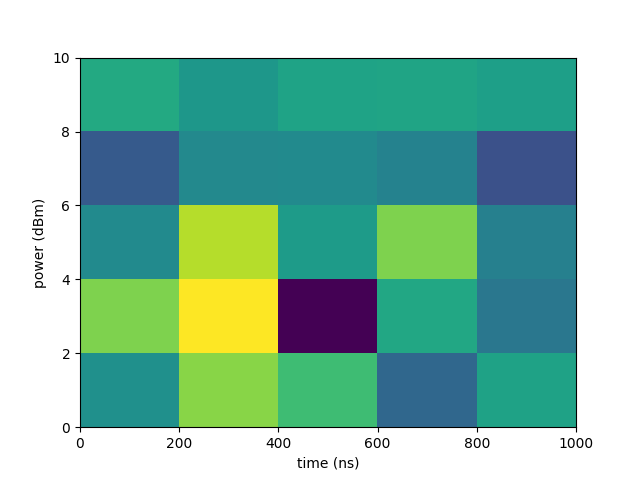

In [65]:
from qulab.tools.fileprocess import *
npz_path='/Users/liuqichun/Desktop/for_test1.npz'
txt_path='/Users/liuqichun/Desktop/'

#npz2txt(npz_path=npz_path,txt_path=txt_path)
for i in [0]:
    record2txt(record=qulab.query('Rabi.three_dim_rabi')[i],
               txt_path=txt_path+'for_png_'+str(i)+'.txt')

<IPython.core.display.Javascript object>


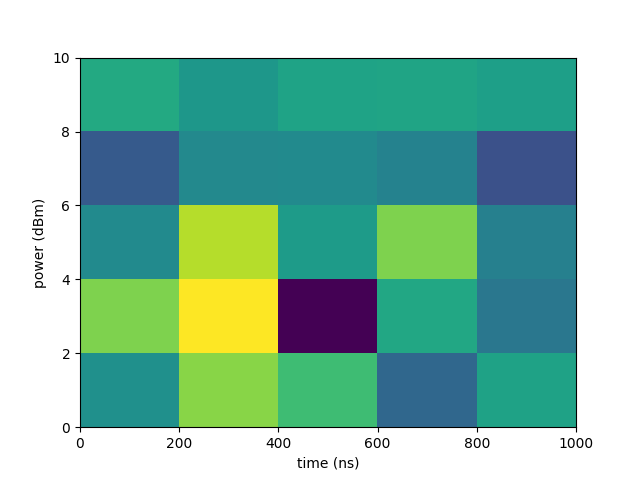

Text(0, 0.5, 'power (dBm)')

In [30]:
## 读取’.npz‘文件绘图
dataout=np.load('tempdata/20190725/for_test.npz')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(dataout['z'], extent=(min(dataout['x'])*1e9, max(dataout['x'])*1e9, 
                                min(dataout['y']), max(dataout['y'])),
          aspect='auto', origin='lower', interpolation='nearest')
ax.set_xlabel('time (ns)')
ax.set_ylabel('power (dBm)')

In [292]:
import re
 
# 将匹配的数字乘以 2
def double(matched):
    value = int(matched.group())
    return str(value * 2)

pattern = re.compile(r'\d+')
s = 'A23G4HFD567'
print(re.sub(r'\d+', double, s))
print(pattern.sub(double,s))

A46G8HFD1134
A46G8HFD1134


In [306]:
x= 'cch2'
pattern = re.compile(r'ch\d')
m = pattern.match(x)
if m is None:
    print('a')

a


In [59]:
import re
a = 'Record by Rabi.rabi_line (v0.0.8)'
b= a.split(' ')
print(b)
print(b[3][1:-1])

['Record', 'by', 'Rabi.rabi_line', '(v0.0.8)']
0.0.
